In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import re
from datetime import datetime

In [2]:
url = "https://www.popvortex.com/music/charts/top-100-songs.php"

In [3]:
response = requests.get(url)

In [4]:
response.status_code

200

In [5]:
soup = BeautifulSoup(response.content, "html.parser")
# soup

In [6]:
song_elements=soup.find_all('div', class_='chart-content')

In [7]:
if not song_elements:
    print("No song elements found. Please check if the website structure has changed.")
    exit()

data = []
for i, element in enumerate(song_elements):
    title = element.find('cite', class_='title').text.strip()
    artist = element.find('em', class_='artist').text.strip()

    # Extracting genre
    genre = "Genre not found"
    ul_tag = element.find('ul')
    if ul_tag:
        for li_tag in ul_tag.find_all('li'):
            if 'Genre' in li_tag.text:
                genre = li_tag.text.strip().replace('Genre:', '')
                break

   # Extracting release date using regular expression
    release_date_text = ""
    release_date_match = re.search(r'Release Date: (\w+ \d{1,2}, \d{4})', element.get_text())
    if release_date_match:
        release_date_text = release_date_match.group(1)
        
        # Convert release date to date format
        release_date = datetime.strptime(release_date_text, "%B %d, %Y").strftime("%d/%m/%Y")

    data.append([title, artist, genre, release_date])

df = pd.DataFrame(data, columns=['song_name', 'name', 'genre', 'release_date'])
df.head()

,song_name,name,genre,release_date
0,TEXAS HOLD 'EM,Beyoncé,Country,11/02/2024
1,Run Back To You,LAY & Lauv,Pop,23/02/2024
2,Wine Into Whiskey,Tucker Wetmore,Country,23/02/2024
3,Lose Control,Teddy Swims,Pop,23/06/2023
4,Beautiful Things,Benson Boone,Pop,19/01/2024


In [8]:
# first ask for a songfrom user
# if title in df then dive new song from df
# if title not in df answer politely 

In [9]:
def recommend_song1(df, input_song):
    # Convert input to lowercase for case-insensitive comparison
    input_song = input_song.lower()
    
    # Check if the input song is in the DataFrame
    if input_song in df['song_name'].str.lower().values:
        # Get a random song that is not the input song
        random_song = df[df['song_name'].str.lower() != input_song].sample(n=1)
        recommended_song1 = random_song.iloc[0]['song_name']
        recommended_artist = random_song.iloc[0]['name']
        print(f"Thanks for answering {input_song}. Based on your input, we reccomend {recommended_song1} by {recommended_artist}.")
    else:
        print("We have no recommendation at this time.")

In [10]:
user_input = input("Enter a song title: ")
recommend_song1(df, user_input)

Enter a song title: flowers
Thanks for answering flowers. Based on your input, we reccomend The Door by Teddy Swims.


# API wrappers

In [11]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from pandas import json_normalize

In [12]:
secrets_file = open("secrets.txt","r")

In [13]:
string = secrets_file.read()

In [14]:
string.split('\n')

['client_id:0a3904a89c3240788c3df162f505438c',
 'client_secret:087560078b984a6ba8972510db24aee9']

In [15]:
secrets_dict={}
for line in string.split('\n'):
    if len(line) > 0:
        #print(line.split(':'))
        secrets_dict[line.split(':')[0]]=line.split(':')[1].strip()

In [16]:
from spotipy.oauth2 import SpotifyClientCredentials

#Initialize SpotiPy with user credentials
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=secrets_dict['client_id'],
                                                           client_secret=secrets_dict['client_secret']))

In [17]:
playlist = sp.user_playlist_tracks("spotify", "1TM3rECdFTc0R0tgiIf0oW")

In [18]:
playlist.keys() 

dict_keys(['href', 'items', 'limit', 'next', 'offset', 'previous', 'total'])

## Additional Playlist and Features

In [19]:
from random import randint
from time import sleep

def get_playlist_tracks(playlist_id):
    results = sp.user_playlist_tracks("spotify",playlist_id)
    tracks = results['items']
    while results['next']!=None:
        results = sp.next(results)
        tracks = tracks + results['items']
        sleep(randint(1,3000)/800) # respectful nap
    return tracks

In [20]:
all_tracks = get_playlist_tracks("1TM3rECdFTc0R0tgiIf0oW")
len(all_tracks)

4690

In [21]:
songs = json_normalize(all_tracks)

In [22]:
# songs

In [23]:
artists_df = pd.DataFrame(columns=['href', 'id', 'name', 'type', 'uri', 'external_urls.spotify','song_id', 'song_name' ])
for i in songs.index:
    artists_for_song = json_normalize(songs.iloc[i]['track.artists'])
    artists_for_song['song_id']    = songs.iloc[i]['track.id']         # we want to keep song_id, it is the same for all artists
    artists_for_song['song_name']  = songs.iloc[i]['track.name']       # we want to keep song_name, it is the sae for all artists
    artists_df = pd.concat([artists_df, artists_for_song], axis=0)

In [24]:
df_final = artists_df[['song_name', 'name', 'song_id']].dropna()
df_final

,song_name,name,song_id
0,Pretty Pimpin,Kurt Vile,3l9eg9RtisizG12a1D6nZl
0,I Need My Girl,The National,50M7nY1oQuNHecs0ahWAtI
0,Strange,Galaxie 500,2TTAPkrGQQOZkaUTUlt21Q
0,Todeswalzer,Windir,7BvcpEdO7PUDGGSER1S9LA
0,Blinding Lights,The Weeknd,0VjIjW4GlUZAMYd2vXMi3b
...,...,...,...
1,Apologize,OneRepublic,6ucR4KfvsBFWCMVFDvyKKl
0,Goddamn Lonely Love - Remastered,Drive-By Truckers,241LK9hqfXJyWpQ7oClQSN
0,Graveless yet Dead,Convocation,6hF9etLMoADWLsoui5ejGW
0,Gimme! Gimme! Gimme! (A Man After Midnight),ABBA,3vkQ5DAB1qQMYO4Mr9zJN6


In [25]:
df_final.isna().sum()

song_name    0
name         0
song_id      0
dtype: int64

In [26]:
list_id = df_final['song_id'][0:5]
list_id

0    3l9eg9RtisizG12a1D6nZl
0    50M7nY1oQuNHecs0ahWAtI
0    2TTAPkrGQQOZkaUTUlt21Q
0    7BvcpEdO7PUDGGSER1S9LA
0    0VjIjW4GlUZAMYd2vXMi3b
Name: song_id, dtype: object

In [27]:
# sp.audio_features(list_id)

In [28]:
chunks = [(i, i+100) for i in range(0, len(df_final), 100)]
# chunks

In [29]:
chunks[0:2]

[(0, 100), (100, 200)]

In [30]:
chunks = [(i, i+100) for i in range(0, len(df_final), 100)]

audio_features_list = []
for chunk in chunks:
    id_list100 = df_final['song_id'][chunk[0]:chunk[1]]
    audio_features_list = audio_features_list + sp.audio_features(id_list100)
    sleep(randint(1,3000)/800)
len(audio_features_list)

4953

In [31]:
# audio_features_list

In [32]:
audio_features_df = json_normalize(audio_features_list)

In [33]:
audio_features_df.drop_duplicates(inplace=True)
audio_features_df.head(5)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.566,0.664,8,-9.081,1,0.0281,0.092800,0.305000,0.0903,0.764,91.117,audio_features,3l9eg9RtisizG12a1D6nZl,spotify:track:3l9eg9RtisizG12a1D6nZl,https://api.spotify.com/v1/tracks/3l9eg9Rtisiz...,https://api.spotify.com/v1/audio-analysis/3l9e...,298760,4
1,0.520,0.436,0,-11.508,0,0.0355,0.865000,0.065100,0.1230,0.114,126.053,audio_features,50M7nY1oQuNHecs0ahWAtI,spotify:track:50M7nY1oQuNHecs0ahWAtI,https://api.spotify.com/v1/tracks/50M7nY1oQuNH...,https://api.spotify.com/v1/audio-analysis/50M7...,245240,4
2,0.312,0.844,7,-7.085,1,0.0511,0.079800,0.023100,0.0793,0.626,97.039,audio_features,2TTAPkrGQQOZkaUTUlt21Q,spotify:track:2TTAPkrGQQOZkaUTUlt21Q,https://api.spotify.com/v1/tracks/2TTAPkrGQQOZ...,https://api.spotify.com/v1/audio-analysis/2TTA...,199467,4
3,0.236,0.870,2,-4.747,0,0.0579,0.000011,0.930000,0.3050,0.186,167.845,audio_features,7BvcpEdO7PUDGGSER1S9LA,spotify:track:7BvcpEdO7PUDGGSER1S9LA,https://api.spotify.com/v1/tracks/7BvcpEdO7PUD...,https://api.spotify.com/v1/audio-analysis/7Bvc...,295131,4
4,0.514,0.730,1,-5.934,1,0.0598,0.001460,0.000095,0.0897,0.334,171.005,audio_features,0VjIjW4GlUZAMYd2vXMi3b,spotify:track:0VjIjW4GlUZAMYd2vXMi3b,https://api.spotify.com/v1/tracks/0VjIjW4GlUZA...,https://api.spotify.com/v1/audio-analysis/0VjI...,200040,4


In [34]:
pd.set_option('display.max_columns', None)
df_audio_features = pd.merge(left=df_final,
                        right=audio_features_df,
                        how='inner',
                        left_on='song_id',
                        right_on='id')
df_audio_features

,song_name,name,song_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,Pretty Pimpin,Kurt Vile,3l9eg9RtisizG12a1D6nZl,0.566,0.664,8,-9.081,1,0.0281,0.092800,0.305000,0.0903,0.764,91.117,audio_features,3l9eg9RtisizG12a1D6nZl,spotify:track:3l9eg9RtisizG12a1D6nZl,https://api.spotify.com/v1/tracks/3l9eg9Rtisiz...,https://api.spotify.com/v1/audio-analysis/3l9e...,298760,4
1,I Need My Girl,The National,50M7nY1oQuNHecs0ahWAtI,0.520,0.436,0,-11.508,0,0.0355,0.865000,0.065100,0.1230,0.114,126.053,audio_features,50M7nY1oQuNHecs0ahWAtI,spotify:track:50M7nY1oQuNHecs0ahWAtI,https://api.spotify.com/v1/tracks/50M7nY1oQuNH...,https://api.spotify.com/v1/audio-analysis/50M7...,245240,4
2,Strange,Galaxie 500,2TTAPkrGQQOZkaUTUlt21Q,0.312,0.844,7,-7.085,1,0.0511,0.079800,0.023100,0.0793,0.626,97.039,audio_features,2TTAPkrGQQOZkaUTUlt21Q,spotify:track:2TTAPkrGQQOZkaUTUlt21Q,https://api.spotify.com/v1/tracks/2TTAPkrGQQOZ...,https://api.spotify.com/v1/audio-analysis/2TTA...,199467,4
3,Todeswalzer,Windir,7BvcpEdO7PUDGGSER1S9LA,0.236,0.870,2,-4.747,0,0.0579,0.000011,0.930000,0.3050,0.186,167.845,audio_features,7BvcpEdO7PUDGGSER1S9LA,spotify:track:7BvcpEdO7PUDGGSER1S9LA,https://api.spotify.com/v1/tracks/7BvcpEdO7PUD...,https://api.spotify.com/v1/audio-analysis/7Bvc...,295131,4
4,Blinding Lights,The Weeknd,0VjIjW4GlUZAMYd2vXMi3b,0.514,0.730,1,-5.934,1,0.0598,0.001460,0.000095,0.0897,0.334,171.005,audio_features,0VjIjW4GlUZAMYd2vXMi3b,spotify:track:0VjIjW4GlUZAMYd2vXMi3b,https://api.spotify.com/v1/tracks/0VjIjW4GlUZA...,https://api.spotify.com/v1/audio-analysis/0VjI...,200040,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4948,Apologize,OneRepublic,6ucR4KfvsBFWCMVFDvyKKl,0.653,0.604,8,-6.017,1,0.0278,0.029200,0.000000,0.0970,0.101,118.016,audio_features,6ucR4KfvsBFWCMVFDvyKKl,spotify:track:6ucR4KfvsBFWCMVFDvyKKl,https://api.spotify.com/v1/tracks/6ucR4KfvsBFW...,https://api.spotify.com/v1/audio-analysis/6ucR...,184400,4
4949,Goddamn Lonely Love - Remastered,Drive-By Truckers,241LK9hqfXJyWpQ7oClQSN,0.427,0.541,7,-7.042,1,0.0294,0.107000,0.004810,0.2230,0.153,119.094,audio_features,241LK9hqfXJyWpQ7oClQSN,spotify:track:241LK9hqfXJyWpQ7oClQSN,https://api.spotify.com/v1/tracks/241LK9hqfXJy...,https://api.spotify.com/v1/audio-analysis/241L...,301720,4
4950,Graveless yet Dead,Convocation,6hF9etLMoADWLsoui5ejGW,0.262,0.689,2,-8.342,1,0.0705,0.036600,0.008330,0.1170,0.178,130.110,audio_features,6hF9etLMoADWLsoui5ejGW,spotify:track:6hF9etLMoADWLsoui5ejGW,https://api.spotify.com/v1/tracks/6hF9etLMoADW...,https://api.spotify.com/v1/audio-analysis/6hF9...,572149,4
4951,Gimme! Gimme! Gimme! (A Man After Midnight),ABBA,3vkQ5DAB1qQMYO4Mr9zJN6,0.749,0.491,10,-9.655,1,0.0403,0.020000,0.008990,0.1590,0.536,119.528,audio_features,3vkQ5DAB1qQMYO4Mr9zJN6,spotify:track:3vkQ5DAB1qQMYO4Mr9zJN6,https://api.spotify.com/v1/tracks/3vkQ5DAB1qQM...,https://api.spotify.com/v1/audio-analysis/3vkQ...,292613,4


## Clustering

In [35]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from matplotlib.lines import Line2D
from sklearn.cluster import KMeans

In [36]:
X_num=df_audio_features.select_dtypes(include=['number'])
X_num

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0.566,0.664,8,-9.081,1,0.0281,0.092800,0.305000,0.0903,0.764,91.117,298760,4
1,0.520,0.436,0,-11.508,0,0.0355,0.865000,0.065100,0.1230,0.114,126.053,245240,4
2,0.312,0.844,7,-7.085,1,0.0511,0.079800,0.023100,0.0793,0.626,97.039,199467,4
3,0.236,0.870,2,-4.747,0,0.0579,0.000011,0.930000,0.3050,0.186,167.845,295131,4
4,0.514,0.730,1,-5.934,1,0.0598,0.001460,0.000095,0.0897,0.334,171.005,200040,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4948,0.653,0.604,8,-6.017,1,0.0278,0.029200,0.000000,0.0970,0.101,118.016,184400,4
4949,0.427,0.541,7,-7.042,1,0.0294,0.107000,0.004810,0.2230,0.153,119.094,301720,4
4950,0.262,0.689,2,-8.342,1,0.0705,0.036600,0.008330,0.1170,0.178,130.110,572149,4
4951,0.749,0.491,10,-9.655,1,0.0403,0.020000,0.008990,0.1590,0.536,119.528,292613,4


In [37]:
scaler = StandardScaler()
scaler = scaler.fit(X_num)
X_prep = scaler.transform(X_num)

# Now, all features will have the same weight.
pd.DataFrame(X_prep,columns=X_num.columns).head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0.733987,-0.398752,0.751737,-0.404737,0.729068,-0.796695,-0.208804,0.213107,-0.762843,1.344064,-1.166039,0.240063,0.233789
1,0.491138,-1.398067,-1.513938,-1.074227,-1.371615,-0.687783,2.811565,-0.501272,-0.565416,-1.114800,0.029047,-0.159999,0.233789
2,-0.606961,0.390181,0.468528,0.145862,0.729068,-0.458186,-0.259652,-0.626340,-0.829256,0.822028,-0.963460,-0.502152,0.233789
3,-1.008189,0.504138,-0.947520,0.790802,-1.371615,-0.358105,-0.571739,2.074245,0.533415,-0.842434,1.458663,0.212937,0.233789
4,0.459463,-0.109477,-1.230729,0.463367,0.729068,-0.330141,-0.566070,-0.694844,-0.766465,-0.282569,1.566759,-0.497869,0.233789


In [38]:
X_prep

array([[ 0.73398732, -0.39875206,  0.75173732, ..., -1.16603931,
         0.24006343,  0.23378889],
       [ 0.49113845, -1.3980672 , -1.51393846, ...,  0.029047  ,
        -0.15999891,  0.23378889],
       [-0.60696081,  0.39018094,  0.46852785, ..., -0.96346027,
        -0.50215238,  0.23378889],
       ...,
       [-0.87092698, -0.28917803, -0.94751952, ...,  0.16782835,
         2.28364796,  0.23378889],
       [ 1.70010349, -1.15700433,  1.31815626, ..., -0.19415938,
         0.19411457,  0.23378889],
       [-1.05042397,  0.9249022 , -1.23072899, ...,  0.49930266,
         1.77243975,  0.23378889]])

In [39]:
kmeans = KMeans(n_clusters=9, random_state=1234)
kmeans.fit(X_prep)

C:\ANACONDA3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=9, random_state=1234)

In [40]:
# Predicting / assigning the clusters:
clusters = kmeans.predict(X_prep)

# Check the size of the clusters
pd.Series(clusters).value_counts().sort_index()

0     702
1     333
2    1018
3     279
4     764
5     602
6      41
7     245
8     969
Name: count, dtype: int64

In [41]:
type(clusters)

numpy.ndarray

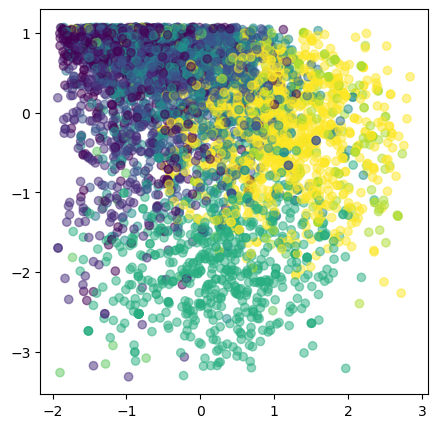

In [42]:
plt.figure(figsize=(5, 5))
plt.scatter(X_prep[:, 0], X_prep[:, 1], c=clusters,alpha=0.5)
plt.show()

In [43]:
kmeans.inertia_ 

36274.62098544038

In [44]:
# %%time
# kmeans = KMeans(n_clusters=9,
#                 init="random",
#                 n_init= 1,  # try with 1, 4, 8, 20, 30, 100...
#                 max_iter=10,
#                 tol=0,
#                 random_state=1234)
# kmeans.fit(X_prep)
# print(kmeans.inertia_)

# Choosing K

In [45]:
# K1 = range(2, 20)
# inertia = []

# for k in K1:
#     kmeans = KMeans(n_clusters=k,
#                     n_init='auto',
#                     random_state=1234)
#     kmeans.fit(X_prep)
#     inertia.append(kmeans.inertia_)

# import matplotlib.pyplot as plt
# %matplotlib inline

# plt.figure(figsize=(16,8))
# plt.plot(K, inertia, 'bx-')
# plt.xlabel('k')
# plt.ylabel('inertia')
# plt.xticks(np.arange(min(K1), max(K1)+1, 1.0))
# plt.title('Elbow Method showing the optimal k')

In [46]:
# from sklearn.metrics import silhouette_score
# K2 = range(2, 20)
# silhouette = []

# for k in K2:
#     kmeans = KMeans(n_clusters=k,
#                     n_init='auto',
#                     random_state=1234)
#     kmeans.fit(X_prep)
#     silhouette.append(silhouette_score(X_prep, kmeans.predict(X_prep)))


# plt.figure(figsize=(16,8))
# plt.plot(K2, silhouette, 'bx-')
# plt.xlabel('k')
# plt.ylabel('silhouette score')
# plt.xticks(np.arange(min(K2), max(K2)+1, 1.0))
# plt.title('Slhouette score showing the optimal k')

In [47]:
# join clusters as a cloumn 
# concat with original df

In [48]:
df_clusters=pd.DataFrame(clusters,columns=['clustr_nu'])
df_clusters.head()

,clustr_nu
0,8
1,5
2,2
3,0
4,2


In [49]:
df_audio_features_final= pd.concat([df_audio_features,df_clusters], axis=1)
df_audio_features_final

,song_name,name,song_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,clustr_nu
0,Pretty Pimpin,Kurt Vile,3l9eg9RtisizG12a1D6nZl,0.566,0.664,8,-9.081,1,0.0281,0.092800,0.305000,0.0903,0.764,91.117,audio_features,3l9eg9RtisizG12a1D6nZl,spotify:track:3l9eg9RtisizG12a1D6nZl,https://api.spotify.com/v1/tracks/3l9eg9Rtisiz...,https://api.spotify.com/v1/audio-analysis/3l9e...,298760,4,8
1,I Need My Girl,The National,50M7nY1oQuNHecs0ahWAtI,0.520,0.436,0,-11.508,0,0.0355,0.865000,0.065100,0.1230,0.114,126.053,audio_features,50M7nY1oQuNHecs0ahWAtI,spotify:track:50M7nY1oQuNHecs0ahWAtI,https://api.spotify.com/v1/tracks/50M7nY1oQuNH...,https://api.spotify.com/v1/audio-analysis/50M7...,245240,4,5
2,Strange,Galaxie 500,2TTAPkrGQQOZkaUTUlt21Q,0.312,0.844,7,-7.085,1,0.0511,0.079800,0.023100,0.0793,0.626,97.039,audio_features,2TTAPkrGQQOZkaUTUlt21Q,spotify:track:2TTAPkrGQQOZkaUTUlt21Q,https://api.spotify.com/v1/tracks/2TTAPkrGQQOZ...,https://api.spotify.com/v1/audio-analysis/2TTA...,199467,4,2
3,Todeswalzer,Windir,7BvcpEdO7PUDGGSER1S9LA,0.236,0.870,2,-4.747,0,0.0579,0.000011,0.930000,0.3050,0.186,167.845,audio_features,7BvcpEdO7PUDGGSER1S9LA,spotify:track:7BvcpEdO7PUDGGSER1S9LA,https://api.spotify.com/v1/tracks/7BvcpEdO7PUD...,https://api.spotify.com/v1/audio-analysis/7Bvc...,295131,4,0
4,Blinding Lights,The Weeknd,0VjIjW4GlUZAMYd2vXMi3b,0.514,0.730,1,-5.934,1,0.0598,0.001460,0.000095,0.0897,0.334,171.005,audio_features,0VjIjW4GlUZAMYd2vXMi3b,spotify:track:0VjIjW4GlUZAMYd2vXMi3b,https://api.spotify.com/v1/tracks/0VjIjW4GlUZA...,https://api.spotify.com/v1/audio-analysis/0VjI...,200040,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4948,Apologize,OneRepublic,6ucR4KfvsBFWCMVFDvyKKl,0.653,0.604,8,-6.017,1,0.0278,0.029200,0.000000,0.0970,0.101,118.016,audio_features,6ucR4KfvsBFWCMVFDvyKKl,spotify:track:6ucR4KfvsBFWCMVFDvyKKl,https://api.spotify.com/v1/tracks/6ucR4KfvsBFW...,https://api.spotify.com/v1/audio-analysis/6ucR...,184400,4,2
4949,Goddamn Lonely Love - Remastered,Drive-By Truckers,241LK9hqfXJyWpQ7oClQSN,0.427,0.541,7,-7.042,1,0.0294,0.107000,0.004810,0.2230,0.153,119.094,audio_features,241LK9hqfXJyWpQ7oClQSN,spotify:track:241LK9hqfXJyWpQ7oClQSN,https://api.spotify.com/v1/tracks/241LK9hqfXJy...,https://api.spotify.com/v1/audio-analysis/241L...,301720,4,2
4950,Graveless yet Dead,Convocation,6hF9etLMoADWLsoui5ejGW,0.262,0.689,2,-8.342,1,0.0705,0.036600,0.008330,0.1170,0.178,130.110,audio_features,6hF9etLMoADWLsoui5ejGW,spotify:track:6hF9etLMoADWLsoui5ejGW,https://api.spotify.com/v1/tracks/6hF9etLMoADW...,https://api.spotify.com/v1/audio-analysis/6hF9...,572149,4,1
4951,Gimme! Gimme! Gimme! (A Man After Midnight),ABBA,3vkQ5DAB1qQMYO4Mr9zJN6,0.749,0.491,10,-9.655,1,0.0403,0.020000,0.008990,0.1590,0.536,119.528,audio_features,3vkQ5DAB1qQMYO4Mr9zJN6,spotify:track:3vkQ5DAB1qQMYO4Mr9zJN6,https://api.spotify.com/v1/tracks/3vkQ5DAB1qQM...,https://api.spotify.com/v1/audio-analysis/3vkQ...,292613,4,8


In [50]:
equal_values = df_audio_features_final['song_id'] == df_audio_features_final['id']
equal_values.value_counts()

True    4953
Name: count, dtype: int64

In [51]:
# drop recurring columns song_id and id
df_audio_features_final =df_audio_features_final.drop('id', axis=1)
df_audio_features_final =df_audio_features_final.drop('type', axis=1)
# df_audio_features_final

In [52]:
csv_Dana_IH_Labs_lab_gnod = 'df_audio_features_final.csv'
df.to_csv(csv_Dana_IH_Labs_lab_gnod, index=False)

## Final stage - Functioning 

In [53]:
# make a function to include the input question
# if song NOT in top 100, first dearch in out df_audio_features_final  
# If song not in out df_audio_features_final , search for audio feature of the requested song by pluging it in spotify to get song_ID
# input song id into code to get the audio features as a new dataframe
# next the new dataframe into our model, find out cluster
# reccomend a song from df_audio_features_final from the same cluster

1- ask for input
2- search the input_song in our df
    3- the input_song is in our df. Go step 5
    4- the song is NOT in hot_songs_df. Go step 6
5- Recommend another song from df. STOP
6- Search in our df_audio_features_final
    7- the input_song is in our df_audio_features_final. Go step 9
    8- the input_song is NOT in our df_audio_features_final. Go step 11
9- Check in which cluster is the input_song
10- Retrieve another song from the same cluster. STOP
11- Get the spotify song_id from the input_song (API spotify)
12- Get the audio_features as a df
13- Put this df in our cluster-model
14- Retrieve the cluster of the input_song
15- Get a recommendation from the same cluster. STOP

In [61]:
def recommend_song(df, df_audio_features_final, input_song, kmeans_model):
    # Step 2: Search the input_song in our df
    input_song_lower = input_song.lower()
    
    if input_song_lower in df['song_name'].str.lower().values:
        # Step 5: Recommend another song from df
        random_song = df[df['song_name'].str.lower() != input_song_lower].sample(n=1)
        recommended_song = random_song.iloc[0]['song_name']
        recommended_artist = random_song.iloc[0]['name']
        print(f"Thanks for answering {input_song}. Based on your input, we recommend {recommended_song} by {recommended_artist}.")
        return
    
    # Step 6: Search in our df_audio_features_final
    if input_song_lower in df_audio_features_final['song_name'].str.lower().values:
        # Step 9: Find cluster of the input_song
        input_song_row = df_audio_features_final[df_audio_features_final['song_name'].str.lower() == input_song_lower].iloc[0]
        input_song_cluster = input_song_row['clustr_nu']
        
        # Step 10: Retrieve another song from the same cluster
        cluster_songs = df_audio_features_final[df_audio_features_final['clustr_nu'] == input_song_cluster]
        
        # Remove the input song from the cluster songs
        cluster_songs = cluster_songs[cluster_songs['song_name'].str.lower() != input_song_lower]
        
        # Check if cluster_songs is not empty, and if not, proceed to get a recommendation from the same cluster
        if not cluster_songs.empty:
            recommended_song_row = cluster_songs.sample(n=1).iloc[0]
            recommended_song = recommended_song_row['song_name']
            recommended_artist = recommended_song_row['name']
            
            # Print the recommendation with cluster info
            print(f"Thanks for answering {input_song}, Cluster {input_song_cluster}. Based on your input, we recommend {recommended_song} by {recommended_artist}, Cluster {input_song_cluster}.")
            return
    
    # Step 11: Get the spotify song_id from the input_song (API spotify)
    # Set your Spotify API credentials
    secrets_dict = {}
    for line in string.split('\n'):
        if len(line) > 0:
            secrets_dict[line.split(':')[0]] = line.split(':')[1].strip()

    sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=secrets_dict['client_id'],
                                                               client_secret=secrets_dict['client_secret']))

    result = sp.search(q=f'track:{input_song}', type='track')
    
    if result['tracks']['items']:
        song_id = result['tracks']['items'][0]['id']
        
        # Step 12: Get the audio_features as a df
        audio_features = sp.audio_features(song_id)
        audio_features_df = pd.DataFrame(audio_features)
        
        # Check if audio_features_df is empty
        if not audio_features_df.empty:
            # Step 13: Put this df in our cluster-model
            audio_features_values = audio_features_df.drop(['id', 'uri', 'track_href', 'analysis_url', 'type'], axis=1)
            audio_features_values = audio_features_df.select_dtypes(include='number')
            
            # Check if the number of features matches the KMeans model
            if audio_features_values.shape[1] == kmeans_model.n_features_in_:
                # Step 14: Retrieve the cluster of the input_song but first scale the df to an array
                audio_features_scaled = scaler.transform(audio_features_values)
                input_song_cluster = kmeans_model.predict(audio_features_scaled)
                                      
                # Step 15: Retrieve another song from the same cluster
                cluster_songs = df_audio_features_final[df_audio_features_final['clustr_nu'] == input_song_cluster[0]]
                
                # Remove the input song from the cluster songs
                cluster_songs = cluster_songs[cluster_songs['song_name'].str.lower() != input_song_lower]
                
                # Check if cluster_songs is not empty, and if not, proceed to get a recommendation from the same cluster
                if not cluster_songs.empty:
                    recommended_song_row = cluster_songs.sample(n=1).iloc[0]
                    recommended_song = recommended_song_row['song_name']
                    recommended_artist = recommended_song_row['name']
                    
                    # Print the recommendation with cluster info
                    print(f"Thanks for answering {input_song}, Cluster {input_song_cluster}. Based on your input, we recommend {recommended_song} by {recommended_artist}, Cluster {input_song_cluster}.")
                    return
    
    print("We have no recommendation at this time.")

# Example usage:
user_input = input("Enter a song title: ")
recommend_song(df, df_audio_features_final, user_input, kmeans)


Enter a song title: pippi langstrumpf
Thanks for answering pippi langstrumpf, Cluster [8]. Based on your input, we recommend Drops of Jupiter (Tell Me) by Train, Cluster [8].
